# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import seaborn as sns
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
import optuna

# Datasets

In [2]:
CTGData=pd.read_csv('CTGNSP selected 20 features.csv')
CTGData.head()

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.0,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,1
1,132,0.006380,0.0,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,0
2,133,0.003322,0.0,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,0
3,134,0.002561,0.0,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,0
4,132,0.006515,0.0,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,0


<AxesSubplot:xlabel='label', ylabel='count'>

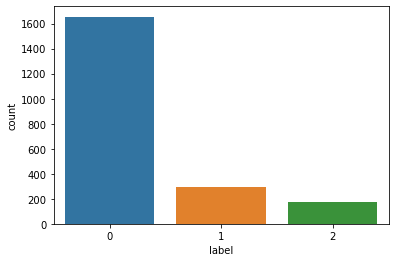

In [3]:
sns.countplot(x='label',data=CTGData)

# Build the model

In [4]:
CTGData.shape

(2126, 21)

In [5]:
CTGData01=CTGData.copy()

In [6]:
X1=CTGData01.drop(labels=['label'],axis=1)

y1=CTGData01['label'].values
y1 = LabelEncoder().fit_transform(y1)

In [7]:
#stanardilization

scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)

### Artificial Neural Network

Load data

In [8]:
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)
print("X_train.shape :",X1_train.shape)
print("X_test.shape :",X1_test.shape)
# print(X_train.head())


X_train.shape : (1700, 20)
X_test.shape : (426, 20)


Define the dataset

In [9]:

X1_train = torch.from_numpy(X1_train)
y1_train = torch.from_numpy(y1_train ).type(torch.LongTensor)

X1_test  = torch.from_numpy(X1_test )
y1_test= torch.from_numpy(y1_test).type(torch.LongTensor)

batch_size = 128

train = torch.utils.data.TensorDataset(X1_train, y1_train )
test = torch.utils.data.TensorDataset(X1_test , y1_test)


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

Define the Optuna  model

In [10]:

# Build a model by implementing define-by-run design from Optuna
def build_model_custom(trial):
    
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 20
# looping to determine the number of layers and nodes in each layer     
    for i in range(n_layers):
#         the number of nodes in each layer.
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        
#         p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
#         layers.append(nn.Dropout(p))
        
        in_features = out_features
        
    layers.append(nn.Linear(in_features, 10))
#     layers.append(nn.ReLU())
    
    return nn.Sequential(*layers)

# Train and evaluate the accuracy of neural network with the addition of pruning mechanism
def train_and_evaluate(param, model, trial):
    


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, param['optimizer'])(model.parameters(), lr= param['learning_rate'])

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(EPOCHS):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in train_loader:

                train_label = train_label.to(device)
                train_input = train_input.to(device)

                output = model(train_input.float())
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in test_loader:

                    val_label = val_label.to(device)
                    val_input = val_input.to(device)

                    output = model(val_input.float())

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            accuracy = total_acc_val/len(test)
            
            # Add prune mechanism
            trial.report(accuracy, epoch_num)

            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

    return accuracy
  
# Define a set of hyperparameter values, build the model, train the model, and evaluate the accuracy
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }
    
    model = build_model_custom(trial)

    accuracy = train_and_evaluate(params, model, trial)

    return accuracy
  
EPOCHS = 30
    
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=30)



[I 2022-09-09 15:02:28,461] A new study created in memory with name: no-name-c1f9f528-1525-4829-8ff9-c963c03041a4
C:\Users\COOLER~1\AppData\Local\Temp/ipykernel_12528/2944855679.py:96: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
[I 2022-09-09 15:02:29,225] Trial 0 finished with value: 0.9131455399061033 and parameters: {'learning_rate': 0.004036439181109626, 'optimizer': 'RMSprop', 'n_layers': 1, 'n_units_l0': 86}. Best is trial 0 with value: 0.9131455399061033.
[I 2022-09-09 15:02:30,208] Trial 1 finished with value: 0.8896713615023474 and parameters: {'learning_rate': 0.0005904648395527698, 'optimizer': 'RMSprop', 'n_layers': 3, 'n_units_l0': 125, 'n_units_l1': 76, 'n_units_l2': 12}. Best is trial 0 with value: 0.9131455399061033.
[I 2022-0

In [11]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.004036439181109626
optimizer: RMSprop
n_layers: 1
n_units_l0: 86


In [12]:
# #  0.9154929577464789.
# learning_rate: 0.041866941177386055
# optimizer: Adam
# n_layers: 1
# n_units_l0: 39


In [13]:
#  0.9178403755868545.
#     learning_rate: 0.009804596280962207
# optimizer: Adam
# n_layers: 1
# n_units_l0: 102



In [14]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


In [15]:
epochs =30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X1.shape[1]
hidden_dim =39 #hidden layer1

output_dim = len(set(y1))

In [16]:
model = ANNModel(input_dim, hidden_dim, output_dim)


learning_rate =0.042
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [17]:
start=datetime.now()
total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) #from double to float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
        #backword propagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # accumulate the loss of each step 
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
training_time_ann='%.4f'%(execution_time_ann).total_seconds()
print(training_time_ann)
        
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) #from double to float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        probs = F.softmax(test_outputs, dim=1) 
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:1.1217 accuracy:0.1094 precision:0.1094 recall:0.1094 f1:0.1094
[sklearn_metrics] Epoch:0 loss:1.8611 accuracy:0.4688 precision:0.4688 recall:0.4688 f1:0.4688
[sklearn_metrics] Epoch:0 loss:2.5995 accuracy:0.5677 precision:0.5677 recall:0.5677 f1:0.5677
[sklearn_metrics] Epoch:0 loss:3.2038 accuracy:0.6113 precision:0.6113 recall:0.6113 f1:0.6113
[sklearn_metrics] Epoch:0 loss:3.6236 accuracy:0.6562 precision:0.6562 recall:0.6562 f1:0.6562
[sklearn_metrics] Epoch:0 loss:4.0026 accuracy:0.6966 precision:0.6966 recall:0.6966 f1:0.6966
[sklearn_metrics] Epoch:0 loss:4.3388 accuracy:0.7277 precision:0.7277 recall:0.7277 f1:0.7277
[sklearn_metrics] Epoch:0 loss:4.7137 accuracy:0.7422 precision:0.7422 recall:0.7422 f1:0.7422
[sklearn_metrics] Epoch:0 loss:5.1060 accuracy:0.7500 precision:0.7500 recall:0.7500 f1:0.7500
[sklearn_metrics] Epoch:0 loss:5.4625 accuracy:0.7586 precision:0.7586 recall:0.7586 f1:0.7586
[sklearn_metrics] Epoch:0 loss:5.8121 accuracy:0.7

[sklearn_metrics] Epoch:6 loss:1.3665 accuracy:0.9268 precision:0.9268 recall:0.9268 f1:0.9268
[sklearn_metrics] Epoch:6 loss:1.6217 accuracy:0.9236 precision:0.9236 recall:0.9236 f1:0.9236
[sklearn_metrics] Epoch:6 loss:1.7691 accuracy:0.9234 precision:0.9234 recall:0.9234 f1:0.9234
[sklearn_metrics] Epoch:6 loss:1.9676 accuracy:0.9205 precision:0.9205 recall:0.9205 f1:0.9205
[sklearn_metrics] Epoch:6 loss:2.0972 accuracy:0.9225 precision:0.9225 recall:0.9225 f1:0.9225
[sklearn_metrics] Epoch:6 loss:2.2709 accuracy:0.9231 precision:0.9231 recall:0.9231 f1:0.9231
[sklearn_metrics] Epoch:6 loss:2.5318 accuracy:0.9229 precision:0.9229 recall:0.9229 f1:0.9229
[sklearn_metrics] Epoch:7 loss:0.1900 accuracy:0.8984 precision:0.8984 recall:0.8984 f1:0.8984
[sklearn_metrics] Epoch:7 loss:0.3263 accuracy:0.9180 precision:0.9180 recall:0.9180 f1:0.9180
[sklearn_metrics] Epoch:7 loss:0.4544 accuracy:0.9219 precision:0.9219 recall:0.9219 f1:0.9219
[sklearn_metrics] Epoch:7 loss:0.7328 accuracy:0.9

[sklearn_metrics] Epoch:14 loss:0.7147 accuracy:0.9121 precision:0.9121 recall:0.9121 f1:0.9121
[sklearn_metrics] Epoch:14 loss:0.8733 accuracy:0.9172 precision:0.9172 recall:0.9172 f1:0.9172
[sklearn_metrics] Epoch:14 loss:1.0873 accuracy:0.9167 precision:0.9167 recall:0.9167 f1:0.9167
[sklearn_metrics] Epoch:14 loss:1.2588 accuracy:0.9174 precision:0.9174 recall:0.9174 f1:0.9174
[sklearn_metrics] Epoch:14 loss:1.3849 accuracy:0.9199 precision:0.9199 recall:0.9199 f1:0.9199
[sklearn_metrics] Epoch:14 loss:1.5148 accuracy:0.9236 precision:0.9236 recall:0.9236 f1:0.9236
[sklearn_metrics] Epoch:14 loss:1.6510 accuracy:0.9250 precision:0.9250 recall:0.9250 f1:0.9250
[sklearn_metrics] Epoch:14 loss:1.8423 accuracy:0.9261 precision:0.9261 recall:0.9261 f1:0.9261
[sklearn_metrics] Epoch:14 loss:1.9652 accuracy:0.9284 precision:0.9284 recall:0.9284 f1:0.9284
[sklearn_metrics] Epoch:14 loss:2.1301 accuracy:0.9285 precision:0.9285 recall:0.9285 f1:0.9285
[sklearn_metrics] Epoch:14 loss:2.2604 a

[sklearn_metrics] Epoch:20 loss:0.8998 accuracy:0.9408 precision:0.9408 recall:0.9408 f1:0.9408
[sklearn_metrics] Epoch:20 loss:0.9918 accuracy:0.9424 precision:0.9424 recall:0.9424 f1:0.9424
[sklearn_metrics] Epoch:20 loss:1.0640 accuracy:0.9453 precision:0.9453 recall:0.9453 f1:0.9453
[sklearn_metrics] Epoch:20 loss:1.1852 accuracy:0.9469 precision:0.9469 recall:0.9469 f1:0.9469
[sklearn_metrics] Epoch:20 loss:1.2672 accuracy:0.9489 precision:0.9489 recall:0.9489 f1:0.9489
[sklearn_metrics] Epoch:20 loss:1.4186 accuracy:0.9486 precision:0.9486 recall:0.9486 f1:0.9486
[sklearn_metrics] Epoch:20 loss:1.5783 accuracy:0.9477 precision:0.9477 recall:0.9477 f1:0.9477
[sklearn_metrics] Epoch:20 loss:1.6427 accuracy:0.9482 precision:0.9482 recall:0.9482 f1:0.9482
[sklearn_metrics] Epoch:21 loss:0.1601 accuracy:0.9375 precision:0.9375 recall:0.9375 f1:0.9375
[sklearn_metrics] Epoch:21 loss:0.2857 accuracy:0.9375 precision:0.9375 recall:0.9375 f1:0.9375
[sklearn_metrics] Epoch:21 loss:0.4045 a

[sklearn_metrics] Epoch:26 loss:1.5270 accuracy:0.9489 precision:0.9489 recall:0.9489 f1:0.9489
[sklearn_metrics] Epoch:26 loss:1.6094 accuracy:0.9488 precision:0.9488 recall:0.9488 f1:0.9488
[sklearn_metrics] Epoch:27 loss:0.1329 accuracy:0.9297 precision:0.9297 recall:0.9297 f1:0.9297
[sklearn_metrics] Epoch:27 loss:0.2222 accuracy:0.9453 precision:0.9453 recall:0.9453 f1:0.9453
[sklearn_metrics] Epoch:27 loss:0.3506 accuracy:0.9505 precision:0.9505 recall:0.9505 f1:0.9505
[sklearn_metrics] Epoch:27 loss:0.5086 accuracy:0.9414 precision:0.9414 recall:0.9414 f1:0.9414
[sklearn_metrics] Epoch:27 loss:0.5944 accuracy:0.9484 precision:0.9484 recall:0.9484 f1:0.9484
[sklearn_metrics] Epoch:27 loss:0.6977 accuracy:0.9479 precision:0.9479 recall:0.9479 f1:0.9479
[sklearn_metrics] Epoch:27 loss:0.8189 accuracy:0.9442 precision:0.9442 recall:0.9442 f1:0.9442
[sklearn_metrics] Epoch:27 loss:0.9120 accuracy:0.9463 precision:0.9463 recall:0.9463 f1:0.9463
[sklearn_metrics] Epoch:27 loss:1.0853 a

In [18]:
training_time_ann

'2.7906'